In [1]:
## for data
import json
import pandas as pd
import numpy as np
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
## for processing
import re
import nltk
## for bag-of-words
from sklearn import metrics, feature_extraction, feature_selection, model_selection, naive_bayes, pipeline, manifold, preprocessing
## for explainer
from lime import lime_text

## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
import torch

## for bert language model
import transformers
from transformers import AutoTokenizer, AutoModel

In [2]:
''' The following shows the result of training various non-neural network models on a transliterated and cleaned
version of the Kannada set. models are trained on an bert vectorizer'''

' The following shows the result of training various non-neural network models on a transliterated and cleaned\nversion of the Kannada set. models are trained on an bert vectorizer'

In [3]:
# import data
kan_train = pd.read_table("../../datasets/task_a/kan_sentiment_train.tsv")
kan_dev = pd.read_table("../../datasets/task_a/kan_sentiment_dev.tsv")

In [4]:
kan_train = kan_train.rename(columns={'category': 'y'})
kan_dev = kan_dev.rename(columns={'category': 'y'})

In [5]:
kan_dev

,text,y
0,Binduge saryagi ugithidira good go ahead we a...,Mixed feelings
1,yen song guru ...super,Positive
2,my fevorat story,not-Kannada
3,Super ತೋಗರಿ ತೀಪ್ಪ,Positive
4,ನಿಮ್ಮ ಮಾತುಗಳು ಅಕ್ಷರಶಃ ಸತ್ಯ... ನಿಮ್ಮ ಈ ಸಾಮಾನ್ಯ ...,Positive
...,...,...
686,@Nandi Parthasarathi ನಿಮ್ಮ ಅಪ್ಪ ದೊಡ್ ಗಾಂಡು ಸೂಳೆಮಗ,Negative
687,Hugi guru badethawke,Negative
688,Trending no.1 wow,Positive
689,@Troll Stupid Fans naanu adikke kano helthirod...,Positive


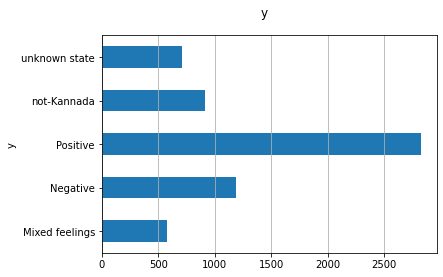

In [6]:
fig, ax = plt.subplots()
fig.suptitle("y", fontsize=12)
kan_train.groupby("y").count().plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

In [7]:
# read in the list of stopwords in Kannada
with open('../stopwords-kn.txt') as file:
    lines = file.readlines()
    lines = [line.rstrip() for line in lines]

lst_stopwords = lines

In [8]:
# transliterate all data from english scrip to kannada script
from indictrans import Transliterator

# instantiate the trasnliteration
trn = Transliterator(source='eng', target='kan', build_lookup=True)

# save the text column as a list in order to improve performance.
orig_kn_train = (kan_train['text'].to_numpy()).tolist()

# create and empty list, iterate through the list of text and append the transliterated text to our list.
list_trans = []
for i in range(len(orig_kn_train)):
    list_trans.append(trn.transform(orig_kn_train[i]))
    
# append the transliterated texts as a column on original dataframe
kan_train['text_trans'] = list_trans

In [9]:
kan_train

,text,y,text_trans
0,ಒಂದು ದೇಶದ ಮುಂದುವರಿಯುವುದು ಅದರ ಆರ್ಥಿಕ ಸ್ಥಿತಿಯನ್ನ...,Negative,ಒಂದು ದೇಶದ ಮುಂದುವರಿಯುವುದು ಅದರ ಆರ್ಥಿಕ ಸ್ಥಿತಿಯನ್ನ...
1,ಕನ್ನಡದಲ್ಲಿ ಡೈಲಿ ಟೆಕ್ ಅಪ್ಡೇಟ್ಸ್ ಪಡೆಯಲು ಸಬ್ಸ್ಕ್ರ...,Positive,ಕನ್ನಡದಲ್ಲಿ ಡೈಲಿ ಟೆಕ್ ಅಪ್ಡೇಟ್ಸ್ ಪಡೆಯಲು ಸಬ್ಸ್ಕ್ರ...
2,Super sar song,not-Kannada,ಸುಪರ್ ಸಾರ ಸೋಂಗ್
3,Tiktokers present situation... nನೋಡುವವರು ಯಾರು ...,Negative,ಟೀಕ್ಟೋಕರ್ಸ್ ಪ್ರಸೇಂಟ್ ಸಿತುಂಏಶನ್... ನನೋಡುವವರು ಯಾ...
4,Super ಸಾಂಗ್ ವೆರಿ ನೈಸ್....,Positive,ಸುಪರ್ ಸಾಂಗ್ ವೆರಿ ನೈಸ್....
...,...,...,...
6207,@A.R.W tumbad tanhaji andhadhun aise bahot h...,not-Kannada,@ಆ.ರ.ವ್ ಟುಂಬಾದ್ ತನ್ಹಾಜಿ ಅಂಧಾಧುನ ಐಸೆ ಬಹೋತ ಹೈ ...
6208,പൊളി ഡാൻസ്🥰 രക്ഷിത് ഷെട്ടി മാസ്സ്,not-Kannada,പൊളി ഡാൻസ്🥰 രക്ഷിത് ഷെട്ടി മാസ്സ്
6209,Bro...nNeen este Roast madudru...China ne beku...,Negative,ಬ್ರೊ...ನ್ನೀನ್ ಎಸ್ಟೆ ರೋಸ್ತ ಮದುದ್ರು...ಚೀನಾ ನೇ ಬೇ...
6210,ಕೌಶಲ್ಯ ಇದ್ದವರ ಸಂಖ್ಯೆ ಕಡಿಮೆ ಇಲ್ಲ ಸರ್ ತುಂಬಾ ಪ್ರತ...,Positive,ಕೌಶಲ್ಯ ಇದ್ದವರ ಸಂಖ್ಯೆ ಕಡಿಮೆ ಇಲ್ಲ ಸರ್ ತುಂಬಾ ಪ್ರತ...


In [10]:
# do the same for the dev data
# save the text column as a list in order to improve performance.
orig_kn_dev = (kan_dev['text'].to_numpy()).tolist()

# create and empty list, iterate through the list of text and append the transliterated text to our list.
list_trans_dev = []
for i in range(len(orig_kn_dev)):
    list_trans_dev.append(trn.transform(orig_kn_dev[i]))
    
# append the transliterated texts as a column on original dataframe
kan_dev['text_trans'] = list_trans_dev

In [11]:
kan_dev

,text,y,text_trans
0,Binduge saryagi ugithidira good go ahead we a...,Mixed feelings,ಬಿಂದೂಗೇ ಸರ್ಯಗೀ ಉಗೀಥೀದೀರಾ ಗುಡ್ ಗೋ ಅಹೆಡ್ ವೇ ಅರೇ...
1,yen song guru ...super,Positive,ಯೇನ ಸೋಂಗ್ ಗುರು ...ಸುಪರ್
2,my fevorat story,not-Kannada,ಮೀ ಫೆವರತ ಸ್ಟೋರಿ
3,Super ತೋಗರಿ ತೀಪ್ಪ,Positive,ಸುಪರ್ ತೋಗರಿ ತೀಪ್ಪ
4,ನಿಮ್ಮ ಮಾತುಗಳು ಅಕ್ಷರಶಃ ಸತ್ಯ... ನಿಮ್ಮ ಈ ಸಾಮಾನ್ಯ ...,Positive,ನಿಮ್ಮ ಮಾತುಗಳು ಅಕ್ಷರಶಃ ಸತ್ಯ... ನಿಮ್ಮ ಈ ಸಾಮಾನ್ಯ ...
...,...,...,...
686,@Nandi Parthasarathi ನಿಮ್ಮ ಅಪ್ಪ ದೊಡ್ ಗಾಂಡು ಸೂಳೆಮಗ,Negative,@ನಂದೀ ಪಾರ್ಥಾಸರಥೀ ನಿಮ್ಮ ಅಪ್ಪ ದೊಡ್ ಗಾಂಡು ಸೂಳೆಮಗ
687,Hugi guru badethawke,Negative,ಹುಗೀ ಗುರು ಬದೇತಾಕೆ
688,Trending no.1 wow,Positive,ಟ್ರೆಂಡಿಂಗ್ ನೋ.1 ವೋ
689,@Troll Stupid Fans naanu adikke kano helthirod...,Positive,@ಟ್ರೋಲ್ ಸ್ತುಪಿಡ್ ಫಂಸ ನಾನು ಆದಿಕಏ ಕಾನೋ ಹೇಲ್ಥೀರೋದ...


In [12]:
'''
Preprocess a string.
:parameter
    :param text: string - name of column containing text
    :param lst_stopwords: list - list of stopwords to remove
:return
    cleaned text
'''
def utils_preprocess_text(text, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## back to string from list
    text = " ".join(lst_text)
    return text

In [13]:
#Now we can apply the preprocessing function to our data

kan_train["text_clean"] = kan_train["text_trans"].apply(lambda x: 
          utils_preprocess_text(x, lst_stopwords=lst_stopwords))

kan_dev["text_clean"] = kan_dev["text_trans"].apply(lambda x: 
          utils_preprocess_text(x, lst_stopwords=lst_stopwords))

In [14]:
kan_train

,text,y,text_trans,text_clean
0,ಒಂದು ದೇಶದ ಮುಂದುವರಿಯುವುದು ಅದರ ಆರ್ಥಿಕ ಸ್ಥಿತಿಯನ್ನ...,Negative,ಒಂದು ದೇಶದ ಮುಂದುವರಿಯುವುದು ಅದರ ಆರ್ಥಿಕ ಸ್ಥಿತಿಯನ್ನ...,ಒದ ದಶದ ಮದವರಯವದ ಆರಥಕ ಸಥತಯನನ ಅವಲಬಸವದಲಲ ಮನವಯತಯಲಲ ...
1,ಕನ್ನಡದಲ್ಲಿ ಡೈಲಿ ಟೆಕ್ ಅಪ್ಡೇಟ್ಸ್ ಪಡೆಯಲು ಸಬ್ಸ್ಕ್ರ...,Positive,ಕನ್ನಡದಲ್ಲಿ ಡೈಲಿ ಟೆಕ್ ಅಪ್ಡೇಟ್ಸ್ ಪಡೆಯಲು ಸಬ್ಸ್ಕ್ರ...,ಕನನಡದಲಲ ಡಲ ಟಕ ಅಪಡಟಸ ಪಡಯಲ ಸಬಸಕರಬ ಮಡ ನಮಮ ಚನನಲಗ
2,Super sar song,not-Kannada,ಸುಪರ್ ಸಾರ ಸೋಂಗ್,ಸಪರ ಸರ ಸಗ
3,Tiktokers present situation... nನೋಡುವವರು ಯಾರು ...,Negative,ಟೀಕ್ಟೋಕರ್ಸ್ ಪ್ರಸೇಂಟ್ ಸಿತುಂಏಶನ್... ನನೋಡುವವರು ಯಾ...,ಟಕಟಕರಸ ಪರಸಟ ಸತಏಶನ ನನಡವವರ ಯರ ನಮಮ ವಡಯನ
4,Super ಸಾಂಗ್ ವೆರಿ ನೈಸ್....,Positive,ಸುಪರ್ ಸಾಂಗ್ ವೆರಿ ನೈಸ್....,ಸಪರ ಸಗ ವರ ನಸ
...,...,...,...,...
6207,@A.R.W tumbad tanhaji andhadhun aise bahot h...,not-Kannada,@ಆ.ರ.ವ್ ಟುಂಬಾದ್ ತನ್ಹಾಜಿ ಅಂಧಾಧುನ ಐಸೆ ಬಹೋತ ಹೈ ...,ಆರವ ಟಬದ ತನಹಜ ಅಧಧನ ಐಸ ಬಹತ ಹ ಪರ ಕಸಕ ಬಟಕ ಕಯ ಫದ ನಹ...
6208,പൊളി ഡാൻസ്🥰 രക്ഷിത് ഷെട്ടി മാസ്സ്,not-Kannada,പൊളി ഡാൻസ്🥰 രക്ഷിത് ഷെട്ടി മാസ്സ്,പള ഡൻസ രകഷത ഷടട മസസ
6209,Bro...nNeen este Roast madudru...China ne beku...,Negative,ಬ್ರೊ...ನ್ನೀನ್ ಎಸ್ಟೆ ರೋಸ್ತ ಮದುದ್ರು...ಚೀನಾ ನೇ ಬೇ...,ಬರನನನ ಎಸಟ ರಸತ ಮದದರಚನ ಬಕ ಅತರ ಇವರನಲ ಗಣ ಥಗಡ ಶತ ಮಡ...
6210,ಕೌಶಲ್ಯ ಇದ್ದವರ ಸಂಖ್ಯೆ ಕಡಿಮೆ ಇಲ್ಲ ಸರ್ ತುಂಬಾ ಪ್ರತ...,Positive,ಕೌಶಲ್ಯ ಇದ್ದವರ ಸಂಖ್ಯೆ ಕಡಿಮೆ ಇಲ್ಲ ಸರ್ ತುಂಬಾ ಪ್ರತ...,ಕಶಲಯ ಇದದವರ ಸಖಯ ಕಡಮ ಇಲಲ ಸರ ತಬ ಪರತಭವತರದದರ ಇನಫಲಎನ...


In [15]:
# Now we can define our training data and our dev data as well as targets
train = kan_train
test = kan_dev

y_train = kan_train['y'].values
y_test = kan_dev['y'].values


In [16]:
# for ensemble: 
results = pd.DataFrame(kan_dev['y'])

# Gettint text embeddings from the bert model

In [17]:
# I'll be using the embeddings from the multilinngual bert model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-uncased')
model = AutoModel.from_pretrained('bert-base-multilingual-uncased').to(device)

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [18]:
# We will start by gathering the embeddings for the validation set
cls_val_list = []
batch_size = 1000

for batch_number, batch_test in test.groupby(np.arange(len(test)) // batch_size):
    # tokanizing the text
    tokenized_val = tokenizer(batch_test["text_clean"].values.tolist() , padding = 'max_length', truncation = True,  return_tensors="pt", max_length=256)

    # move on device (GPU)
    tokenized_val = {k:torch.tensor(v).to(device) for k,v in tokenized_val.items()}

    # get the cls hidden state
    with torch.no_grad():
        hidden_val = model(**tokenized_val)
            
    #get only the [CLS] hidden states
    cls_val = hidden_val.last_hidden_state[:,0,:]
    cls_val = cls_val.to("cpu")
    cls_val_list.append(cls_val)
    del cls_val
    del hidden_val
    del tokenized_val
    
    torch.cuda.empty_cache()

cls_val_list_final = []
for i in range(len(cls_val_list)):
    for j in range(len(cls_val_list[i])):
        cls_val_list_final.append(cls_val_list[i][j])


/home/ubuntu/pyenv/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


In [19]:
# Get embeddigns for the trainins set
cls_train_list = []
batch_size = 1000

for batch_number, batch_train in train.groupby(np.arange(len(train)) // batch_size):
    # tokanizing the text
    tokenized_train = tokenizer(batch_train["text_clean"].values.tolist() , padding = 'max_length', truncation = True,  return_tensors="pt", max_length=256)

    # move on device (GPU)
    tokenized_train = {k:torch.tensor(v).to(device) for k,v in tokenized_train.items()}

    # get the cls hidden state
    with torch.no_grad():
        hidden_train = model(**tokenized_train)
            
    #get only the [CLS] hidden states
    cls_train = hidden_train.last_hidden_state[:,0,:]
    cls_train = cls_train.to("cpu")
    cls_train_list.append(cls_train)
    del cls_train
    del hidden_train
    del tokenized_train
    
    torch.cuda.empty_cache()

cls_train_list_final = []
for i in range(len(cls_train_list)):
    for j in range(len(cls_train_list[i])):
        cls_train_list_final.append(cls_train_list[i][j])

/home/ubuntu/pyenv/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


In [20]:
# Move the poutput embeddigns for the trainign and validation sets into a dataframe
X_train = torch.stack(cls_train_list_final)
X_train = pd.DataFrame(X_train)

X_test = torch.stack(cls_val_list_final)
X_test = pd.DataFrame(X_test)

y_train = kan_train['y'].values
y_test = kan_dev['y'].values

# Training a cat boost classifier

In [21]:
from catboost import CatBoostClassifier
cat = CatBoostClassifier(iterations=150, learning_rate=.5)

In [22]:
## train classifier
cat.fit(X_train, y_train)
predicted = cat.predict(X_test)
results['cat_boost_cleaned_bert'] = predicted
predicted_prob = cat.predict_proba(X_test)

0:	learn: 1.3942988	total: 596ms	remaining: 1m 28s
1:	learn: 1.3265240	total: 951ms	remaining: 1m 10s
2:	learn: 1.2782460	total: 1.34s	remaining: 1m 5s
3:	learn: 1.2431024	total: 1.74s	remaining: 1m 3s
4:	learn: 1.2100898	total: 2.1s	remaining: 1m
5:	learn: 1.1901691	total: 2.46s	remaining: 58.9s
6:	learn: 1.1661307	total: 2.83s	remaining: 57.9s
7:	learn: 1.1497834	total: 3.19s	remaining: 56.7s
8:	learn: 1.1345137	total: 3.56s	remaining: 55.8s
9:	learn: 1.1212390	total: 3.92s	remaining: 54.9s
10:	learn: 1.1104832	total: 4.28s	remaining: 54s
11:	learn: 1.1008817	total: 4.63s	remaining: 53.2s
12:	learn: 1.0846930	total: 4.99s	remaining: 52.6s
13:	learn: 1.0722295	total: 5.35s	remaining: 52s
14:	learn: 1.0591695	total: 5.71s	remaining: 51.4s
15:	learn: 1.0427979	total: 6.09s	remaining: 51s
16:	learn: 1.0303178	total: 6.44s	remaining: 50.4s
17:	learn: 1.0204147	total: 6.8s	remaining: 49.9s
18:	learn: 1.0112855	total: 7.14s	remaining: 49.2s
19:	learn: 1.0005360	total: 7.49s	remaining: 48.7s

Accuracy: 0.53
Auc: 0.74
Detail:
                precision    recall  f1-score   support

Mixed feelings       0.24      0.10      0.14        52
      Negative       0.48      0.40      0.44       139
      Positive       0.57      0.72      0.64       321
   not-Kannada       0.61      0.55      0.58       110
 unknown state       0.31      0.22      0.26        69

      accuracy                           0.53       691
     macro avg       0.44      0.40      0.41       691
  weighted avg       0.51      0.53      0.51       691



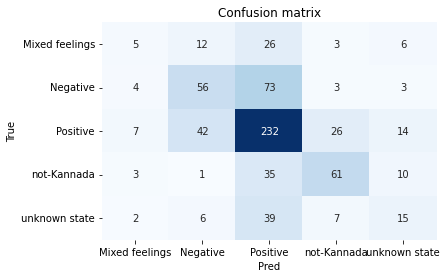

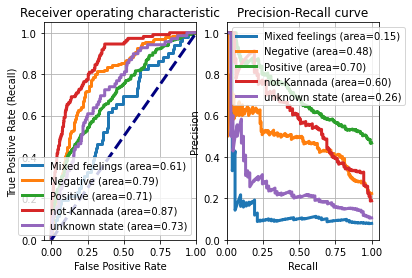

In [23]:
# lets see our model performance
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# Training a Random Forest Classifier

In [24]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(max_depth=150, n_estimators=15, max_features=768)

In [25]:
## train classifier
forest.fit(X_train, y_train)
## test
predicted = forest.predict(X_test)
results['forest_cleaned_bert'] = predicted
predicted_prob = forest.predict_proba(X_test)

Accuracy: 0.51
Auc: 0.71
Detail:
                precision    recall  f1-score   support

Mixed feelings       0.26      0.10      0.14        52
      Negative       0.42      0.35      0.38       139
      Positive       0.55      0.76      0.64       321
   not-Kannada       0.59      0.44      0.50       110
 unknown state       0.24      0.10      0.14        69

      accuracy                           0.51       691
     macro avg       0.41      0.35      0.36       691
  weighted avg       0.48      0.51      0.48       691



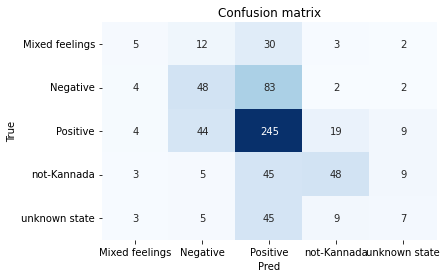

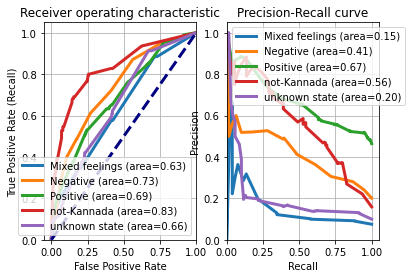

In [26]:
# lets see our model performance
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# fitting a logistic regression classifier

In [27]:
from sklearn.linear_model import LogisticRegression
log =LogisticRegression(random_state=0, max_iter= 300)

In [28]:
## pipeline

## train classifier
log.fit(X_train, y_train)
## test
predicted = log.predict(X_test)
results['log_cleaned_bert'] = predicted
predicted_prob = log.predict_proba(X_test)

/home/ubuntu/pyenv/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy: 0.58
Auc: 0.81
Detail:
                precision    recall  f1-score   support

Mixed feelings       0.00      0.00      0.00        52
      Negative       0.57      0.46      0.51       139
      Positive       0.59      0.83      0.69       321
   not-Kannada       0.63      0.52      0.57       110
 unknown state       0.42      0.20      0.27        69

      accuracy                           0.58       691
     macro avg       0.44      0.40      0.41       691
  weighted avg       0.53      0.58      0.54       691



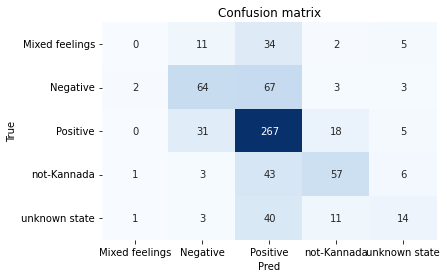

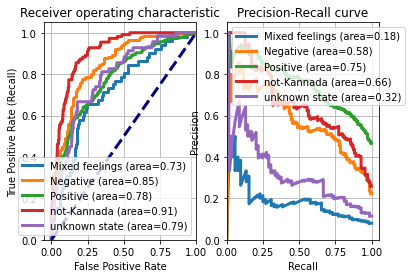

In [29]:
# lets see our model performance
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# training a k-neighboot classifier

In [30]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3, weights='distance')

In [31]:

## train classifier
neigh.fit(X_train, y_train)
## test
predicted = neigh.predict(X_test)
results['neigh_cleaned_bert'] = predicted
predicted_prob = neigh.predict_proba(X_test)

Accuracy: 0.54
Auc: 0.69
Detail:
                precision    recall  f1-score   support

Mixed feelings       0.17      0.13      0.15        52
      Negative       0.56      0.46      0.51       139
      Positive       0.61      0.70      0.65       321
   not-Kannada       0.55      0.52      0.54       110
 unknown state       0.31      0.29      0.30        69

      accuracy                           0.54       691
     macro avg       0.44      0.42      0.43       691
  weighted avg       0.53      0.54      0.53       691



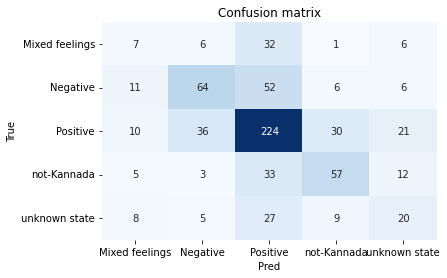

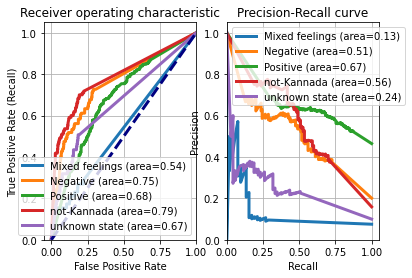

In [32]:
# lets see our model performance
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, predicted_prob, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, predicted))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()

# Ensemble 

In [33]:
results.replace(['Negative', 'Positive','not-Kannada', 'Mixed feelings','unknown state' ], [0,1,2,3,4], inplace=True)
results['cleaned_majority_label_bert'] = results[results.columns[1:]].mode(axis=1)[0].astype(int)
results.replace([0,1,2,3,4], ['Negative', 'Positive','not-Kannada', 'Mixed feelings','unknown state' ], inplace=True)
results.to_csv('kan_results_cleaned_bert.tsv', sep="\t", index = False)

                precision    recall  f1-score   support

Mixed feelings       0.43      0.06      0.10        52
      Negative       0.55      0.51      0.53       139
      Positive       0.58      0.81      0.67       321
   not-Kannada       0.63      0.47      0.54       110
 unknown state       0.45      0.14      0.22        69

      accuracy                           0.57       691
     macro avg       0.53      0.40      0.41       691
  weighted avg       0.56      0.57      0.53       691



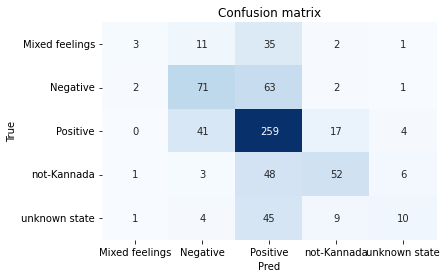

In [34]:
## Plot confusion matrix
print(metrics.classification_report(results['y'], results['cleaned_majority_label_bert']))
cm = metrics.confusion_matrix(results['y'], results['cleaned_majority_label_bert'])
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)
plt.show()